# Predicting EEG time series

**Authors**:

 - Javi Rameerez javi@rameerez.com | [@rameerez [tw]](http://twitter.com/rameerez)

---

_This code is Open Source, released under a GPL License._

Our goal is to use some kind of mathematical model, more concisely machine learning models, to model the behavior of our EEG time series.

Our first guess will be to use deep Recurrent Neural Networks (RNN) based on LSTM cells.

## Single-variable time series modelling with LSTM-based RNNs

Based on [this](https://github.com/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb) notebook.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [43]:
df = pd.read_csv("data/2-thinking-about-moving-hands-1-BBT-E16-AAA005-2019-11-08_18-40-17/EEG.csv")

In [44]:
df.head()

,timestamp,sequence,battery,flags,EEG-ch1,EEG-ch2,EEG-ch3,EEG-ch4,EEG-ch5,EEG-ch6,EEG-ch7,EEG-ch8,EEG-ch9,EEG-ch10,EEG-ch11,EEG-ch12,EEG-ch13,EEG-ch14,EEG-ch15,EEG-ch16
0,11002356847,19440,-2,0,28375.884227,6223.655248,4573.301857,12550.176205,-46087.548753,-3893.383126,-51657.105123,-58516.230505,-11171.284130,-39439.399066,-53518.811408,-23091.210143,-36824.889547,-8738.718181,-15298.457383,-2868.193830
1,11002356847,19440,-2,0,28371.576862,6201.108506,4573.265354,12544.420884,-46086.100797,-3893.005928,-51655.803179,-58514.819052,-11171.454478,-39437.951110,-53516.730732,-23089.920367,-36825.802124,-8739.156218,-15297.240613,-2867.037899
2,11002356847,19440,-2,0,28370.506105,6200.171593,4573.873739,12542.182028,-46086.392822,-3891.460630,-51654.452565,-58514.770382,-11170.140367,-39437.719924,-53516.706396,-23088.618423,-36823.916131,-8741.346404,-15302.886425,-2872.063158
3,11002356847,19440,-2,0,28372.477272,6224.811179,4570.819647,12543.240618,-46088.071964,-3893.310120,-51656.448067,-58518.201672,-11172.245378,-39438.364812,-53519.310283,-23090.285398,-36824.938217,-8744.059800,-15310.320888,-2882.612551
4,11002356847,19440,-2,0,28370.092403,6218.228455,4571.014330,12541.439799,-46088.607343,-3894.648567,-51657.737843,-58519.235926,-11172.452229,-39439.691091,-53520.733904,-23091.039795,-36826.690366,-8742.392826,-15311.574160,-2883.196601


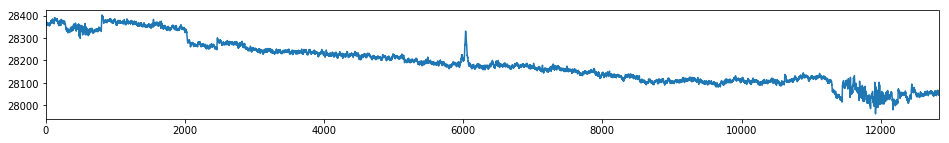

In [46]:
df["EEG-ch1"].plot(figsize=(16,2));

In [47]:
training_set = df["EEG-ch1"].values

In [48]:
training_set

array([28375.88422679, 28371.57686211, 28370.50610479, ...,
       28047.17389712, 28047.00354936, 28048.4028345 ])

In [49]:
# Required for Scikitlearn to rescale
training_set = training_set.reshape(-1,1)

In [50]:
training_set

array([[28375.88422679],
       [28371.57686211],
       [28370.50610479],
       ...,
       [28047.17389712],
       [28047.00354936],
       [28048.4028345 ]])

### Data splitting

In [51]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [52]:
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

### Defining our LSTM neural network

In [53]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

### Training the neural net

In [54]:
num_epochs = 200
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 10 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.62038
Epoch: 10, loss: 0.23084
Epoch: 20, loss: 0.03076
Epoch: 30, loss: 0.04937
Epoch: 40, loss: 0.02777
Epoch: 50, loss: 0.02850
Epoch: 60, loss: 0.02443
Epoch: 70, loss: 0.02250
Epoch: 80, loss: 0.01975
Epoch: 90, loss: 0.01715
Epoch: 100, loss: 0.01411
Epoch: 110, loss: 0.01096
Epoch: 120, loss: 0.00791
Epoch: 130, loss: 0.00514
Epoch: 140, loss: 0.00289
Epoch: 150, loss: 0.00132
Epoch: 160, loss: 0.00046
Epoch: 170, loss: 0.00015
Epoch: 180, loss: 0.00010
Epoch: 190, loss: 0.00011


### Predicting (overfitted data)

In [55]:
lstm.eval()
train_predict = lstm(dataX)

In [56]:
train_predict.data.numpy()

array([[0.92540526],
       [0.9236368 ],
       [0.9237139 ],
       ...,
       [0.23110685],
       [0.22384694],
       [0.220435  ]], dtype=float32)

In [57]:
dataY.data.numpy()

array([[0.9263466 ],
       [0.9289445 ],
       [0.93709755],
       ...,
       [0.18995108],
       [0.19288063],
       [0.1924937 ]], dtype=float32)

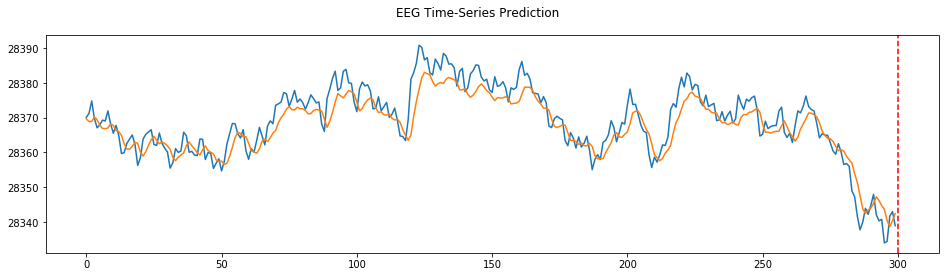

In [58]:
trim_to = 300 ## or train_size

data_predict = train_predict.data.numpy()[:trim_to]
dataY_plot = dataY.data.numpy()[:trim_to]

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(16,4))

plt.axvline(x=trim_to, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('EEG Time-Series Prediction')
plt.show()

## Is it generalizing well?

In [42]:
df_test = pd.read_pickle("data/3-thinking-about-moving-hands-2-BBT-E16-AAA005-2019-11-08_18-45-48/labelled-eeg.pkl")

In [59]:
df_test.head()

,timestamp,sequence,battery,flags,EEG-ch1,EEG-ch2,EEG-ch3,EEG-ch4,EEG-ch5,EEG-ch6,...,EEG-ch9,EEG-ch10,EEG-ch11,EEG-ch12,EEG-ch13,EEG-ch14,EEG-ch15,EEG-ch16,label,label_code
0,11333317601,24377,-2,0,26244.797302,14440.732099,5991.811953,12210.174253,-45292.170747,-11380.008801,...,-7832.273439,-37863.463309,-51954.398459,-22407.896624,-35959.960986,-9194.593110,-11373.864115,-1316.946330,none,-1
1,11333317601,24377,-2,0,26243.252005,14437.422485,5986.409495,12208.555949,-45295.078827,-11383.062893,...,-7834.609637,-37864.509731,-51954.921670,-22409.685276,-35960.545035,-9197.476855,-11376.346325,-1316.435287,none,-1
2,11333317601,24377,-2,0,26238.092901,14432.640580,5983.099882,12203.834883,-45298.497950,-11384.973222,...,-7838.539803,-37869.315971,-51959.910426,-22412.629859,-35963.842481,-9202.429107,-11381.164733,-1318.832323,none,-1
3,11333317601,24377,-2,0,26233.603021,14429.257961,5980.106628,12198.310748,-45303.377196,-11389.098071,...,-7841.472218,-37872.674256,-51965.872598,-22416.925056,-35967.152095,-9205.544038,-11385.034060,-1321.363204,none,-1
4,11333317601,24377,-2,0,26235.939219,14427.140781,5978.111126,12200.598275,-45305.749897,-11390.241834,...,-7843.735409,-37874.681925,-51968.707671,-22420.599700,-35969.196268,-9208.087086,-11386.396842,-1321.886415,none,-1


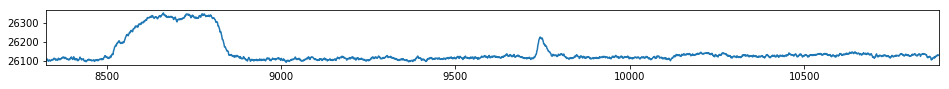

In [61]:
df_test.loc[df_test['label'] == "rest"]["EEG-ch1"].plot(figsize=(16, 1));

In [82]:
test_set = df_test["EEG-ch2"].values
test_set = test_set.reshape(-1,1)

sc = MinMaxScaler()
test_data = sc.fit_transform(test_set)

seq_length = 4
x, y = sliding_windows(test_data, seq_length)

testX = Variable(torch.Tensor(np.array(x)))
testY = Variable(torch.Tensor(np.array(y)))

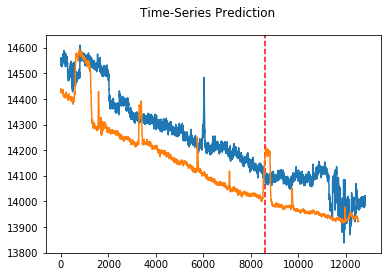

In [83]:
lstm.eval()
test_predict = lstm(testX)

data_predict = test_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()